In [440]:
include("TDCM_modelling.jl")

In [3]:
using RCall

R"""
load("TDCM_Multilevel_data_three_skills.RData")
"""
TDCM_data = @rget data
Y = Array{Int, 3}(TDCM_data[:Y])
Q = convert(Matrix{Int64}, TDCM_data[:Q_matrix])
U = Vector{Vector{Matrix{Float64}}}(TDCM_data[:X_group])
for skill in TDCM_data[:X_ind]
    for time in 1:length(skill)
        if skill[time] isa Vector{<: Number}
            skill[time] = reshape(skill[time], :, 1)
        end
    end
end
X = Vector{Vector{Matrix{Float64}}}(TDCM_data[:X_ind])
group = Vector{Int64}(TDCM_data[:group])
obs = TDCMObs(Y, Q, U, X, group)

# R"""
# load("TDCM_multilevel_J50_data.RData")
# """
# TDCM_J50_data = @rget data_large_questions
# Y = Array{Int, 3}(TDCM_J50_data[:Y])
# Q = convert(Matrix{Int64}, TDCM_J50_data[:Q_matrix])
# U = Vector{Vector{Matrix{Float64}}}(TDCM_J50_data[:X_group])
# for skill in TDCM_J50_data[:X_ind]
#     for time in 1:length(skill)
#         if skill[time] isa Vector{<: Number}
#             skill[time] = reshape(skill[time], :, 1)
#         end
#     end
# end
# X = Vector{Vector{Matrix{Float64}}}(TDCM_J50_data[:X_ind])
# group = Vector{Int64}(TDCM_J50_data[:group])
# obs_J50 = TDCMObs(Y, Q, U, X, group)
;

In [4]:
N, O, J, K, L, S = size(obs.Y, 1), size(obs.Y, 2), size(obs.Y, 3),  size(obs.Q, 2), size(obs.D[1], 1), size(obs.U[1][1], 1)

mu_beta_prior = Vector{Vector{Float64}}(undef, J)
L_beta_prior = Vector{Matrix{Float64}}(undef, J)
for j in 1:J
    num_features = size(obs.D[j], 2)
    mu_beta_prior[j] = zeros(num_features)
    L_beta_prior[j] = Matrix(1.0I, num_features, num_features)
end

mu_omega_prior = Vector{Vector{Vector{Vector{Vector{Float64}}}}}(undef, K)
L_omega_prior = Vector{Vector{Vector{Vector{Matrix{Float64}}}}}(undef, K)
a_tau_prior = Vector{Vector{Vector{Vector{Float64}}}}(undef, K)
b_tau_prior = Vector{Vector{Vector{Vector{Float64}}}}(undef, K)

for k in 1:K
    mu_omega_prior[k] = Vector{Vector{Vector{Vector{Float64}}}}(undef, O)
    L_omega_prior[k] = Vector{Vector{Vector{Matrix{Float64}}}}(undef, O)
    a_tau_prior[k] = Vector{Vector{Vector{Float64}}}(undef, O)
    b_tau_prior[k] = Vector{Vector{Vector{Float64}}}(undef, O)
    for t in 1:O
        num_features_gamma = size(obs.X[k][t], 2)
        num_features_omega = size(obs.U[k][t], 2)
        if t == 1
            mu_omega_prior[k][t] = Vector{Vector{Vector{Float64}}}(undef, 1)
            mu_omega_prior[k][t][1] = Vector{Vector{Float64}}(undef, 1)
            mu_omega_prior[k][t][1][1] = zeros(num_features_omega)

            L_omega_prior[k][t] = Vector{Vector{Matrix{Float64}}}(undef, 1)
            L_omega_prior[k][t][1] = Vector{Matrix{Float64}}(undef, 1)
            L_omega_prior[k][t][1][1] = Matrix{Float64}(1.0I, num_features_omega, num_features_omega)

            a_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 1)
            a_tau_prior[k][t][1] = [.01]

            b_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 1)
            b_tau_prior[k][t][1] = [.01]
        else
            mu_omega_prior[k][t] = Vector{Vector{Vector{Float64}}}(undef, 2)
            L_omega_prior[k][t] = Vector{Vector{Matrix{Float64}}}(undef, 2)
            a_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 2)
            b_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 2)
            for z in 1:2
                mu_omega_prior[k][t][z] = Vector{Vector{Float64}}(undef, num_features_gamma)
                L_omega_prior[k][t][z] = Vector{Matrix{Float64}}(undef, num_features_gamma)
                a_tau_prior[k][t][z] = ones(num_features_gamma) .* .01
                b_tau_prior[k][t][z] = ones(num_features_gamma) .* .01
                for m in 1:num_features_gamma
                    mu_omega_prior[k][t][z][m] = zeros(num_features_omega)
                    L_omega_prior[k][t][z][m] = Matrix{Float64}(1.0I, num_features_omega, num_features_omega)
                end
            end
        end
    end
end

M = 100
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true)

# J50 = size(obs_J50.Y, 3)
# mu_beta_prior = Vector{Vector{Float64}}(undef, J50)
# V_beta_prior = Vector{Matrix{Float64}}(undef, J50)
# for j in 1:J50
#     num_features = size(obs_J50.D[j], 2)
#     mu_beta_prior[j] = zeros(num_features)
#     V_beta_prior[j] = Matrix(1.0I, num_features, num_features)
# end
# model_J50 = TDCModel(obs_J50, mu_beta_prior, V_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=false)
;

TDCModel constructed for computation on 16 threads


In [48]:
# @resumable pi_t1_loglike = function(Z :: Vector{Int}, Y, :: Vector{Int}, D_beta :: Vector{AbstractFloat})
#     for m in 1:model.M
#         J = size(Y)
#         log_prob_YZ = 0
#         for j in 1:J
#             mul!(D_beta, D[j], beta_sample[j][m])
#             log_prob_YZ += dot(z_im, log.(sigmoid.((2*Y[i, 1, j] - 1) .* D_beta)))
#         end
#         skill_profile = obs.skill_dict[argmax(z_im)]
#         for k in 1:K
#             log_prob_YZ += log(sigmoid((2*skill_profile[k] - 1) * dot(gamma_sample[k][1][1][group_i][m], obs.X[k][1][i])))
#         end
#     end
# end

**Estimating attribute profiles from uniform initialization**

In [56]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [57]:
# Fix true values of gamma and betas
for k in 1:K
    for s in S
        model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
        model.V_gamma_star[k][1][1][s] = model.V_gamma_star[k][1][1][s] ./ 100
    end
end

# Initialize in correct direction
for j in 1:J
    # model.mu_beta_star[j] = cat(-1, ones(length(model.mu_beta_star[j]) - 1), dims=1)
    model.mu_beta_star[j] = data[:beta][j]
    model.V_beta_star[j] = model.V_beta_star[j] ./ 100
end

# Sample beta and gammas
sample_β(model)
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

In [58]:
for i in 1:50
    update_categorical_variational_distribution(model, step=.02, maxiter=1, verbose=false)
    update_categorical_variational_distribution2(model, 2, step=.02, maxiter=1, verbose=false)
    update_normal_variational_distribution(model, init_step = .06, maxiter = 3, verbose = false)
end

In [59]:
# skill_profiles = Dict(1=>[0, 0], 
#                  2=>[0, 1],
#                  3=>[1, 0],
#                  4=>[1, 1])

# skill_numbers = Dict([0, 0]=>1, 
#                  [0, 1]=>2,
#                  [1, 0]=>3,
#                  [1, 1]=>4)
skill_profiles = Dict(1=>[0, 0, 0], 
                 2=>[0, 0, 1],
                 3=>[0, 1, 0],
                 4=>[0, 1, 1],
                 5=>[1, 0, 0],
                 6=>[1, 0, 1],
                 7=>[1, 1, 0],
                 8=>[1, 1, 1])

skill_numbers = Dict([0, 0, 0]=>1, 
                 [0, 0, 1]=>2,
                 [0, 1, 0]=>3,
                 [0, 1, 1]=>4,
                 [1, 0, 0]=>5,
                 [1, 0, 1]=>6,
                 [1, 1, 0]=>7,
                 [1, 1, 1]=>8)


preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:5000
    pred = skill_profiles[argmax(model.pi_star[i][1])]
    actual = Vector{Int}(data[:profiles][i, :, 1])
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
    # if !correct
    #     print(Vector{Int}(data[:profiles][i, 1, :]))
    #     println(model.pi_star[i][1])
    # end
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
;

In [60]:
attribute_accs

8-element Vector{Float64}:
 0.912
 0.8484398216939079
 0.895500725689405
 0.9709864603481625
 0.9453978159126365
 0.9198473282442748
 0.962457337883959
 0.9959595959595959

In [61]:
preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:5000
    pred = skill_profiles[argmax(model.pi_star[i][2])]
    actual = Vector{Int}(data[:profiles][i, :, 2])
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
    # if !correct
    #     print(Vector{Int}(data[:profiles][i, 1, :]))
    #     println(model.pi_star[i][1])
    # end
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
;

In [62]:
attribute_accs

8-element Vector{Float64}:
 0.9142857142857143
 0.8970099667774086
 0.8923076923076924
 0.9761904761904762
 0.953405017921147
 0.9442508710801394
 0.9470899470899471
 0.9973172367538564

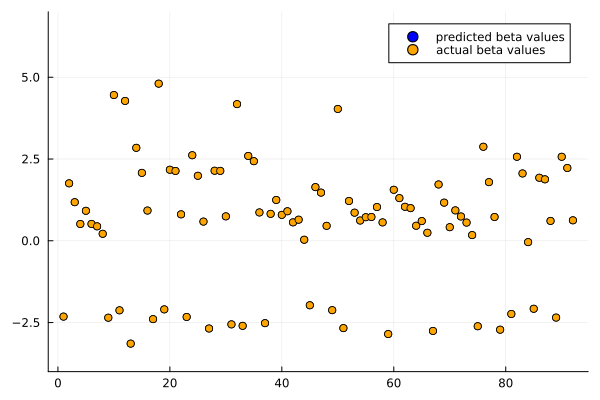

In [63]:
pred_beta_values = []
actual_beta_values = []
for j in 1:J
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data[:beta][j]
        push!(actual_beta_values, val)
    end
end

using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
#plot!(x, pred_beta_values, label = "", lc=:blue)
#plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-4, 7)

**Estimating Item response parameters with correct attribute profiles**

In [97]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [98]:
# profile_to_ind = Dict([0, 0]=>[0.997, 0.001, 0.001, 0.001], 
#                  [0, 1]=>[0.001, 0.997, 0.001, 0.001],
#                  [1, 0]=>[0.001, 0.001, 0.997, 0.001],
#                  [1, 1]=>[0.001, 0.001, 0.001, 0.997])

profile_to_ind = Dict([0, 0, 0] => [0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], 
                 [0, 0, 1] => [0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 0] => [0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 1] => [0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001],
                 [1, 0, 0] => [0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001],
                 [1, 0, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001],
                 [1, 1, 0] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001],
                 [1, 1, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993])

# Fix true values of pi
for i in 1:N
    for t in 1:O
        model.pi_star[i][t] .= profile_to_ind[Vector{Int}(data[:profiles][i, :, t])]
    end
end

# Sample Z values
for i in 1:N
    for t in 1:O
        sample_Z(model, i, t)
    end
end

In [99]:
update_normal_variational_distribution(model, init_step = .06, maxiter = 500, verbose = false)

In [100]:
pred_beta_values = []
actual_beta_values = []
for j in 1:J
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data[:beta][j]
        push!(actual_beta_values, val)
    end
end

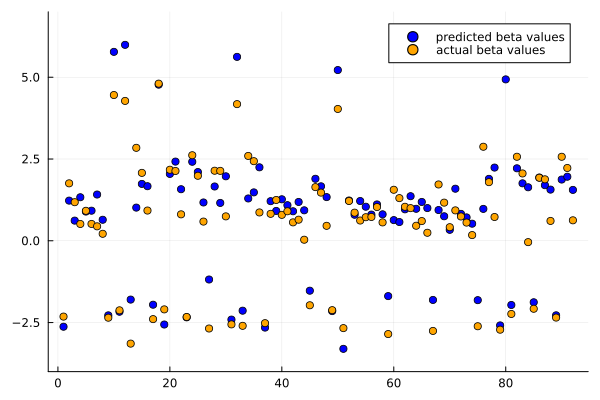

In [101]:
using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
#plot!(x, pred_beta_values, label = "", lc=:blue)
#plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-4, 7)

In [102]:
model.V_beta_star

21-element Vector{Matrix{Float64}}:
 [0.08449485736247811 -0.08096264812569615 … 0.007604753281470202 0.04928951955082824; -0.08096264812569615 0.38214573001169994 … 0.025931603586114543 -0.07310681250564639; … ; 0.007604753281470202 0.025931603586114543 … 0.4293167545537771 -0.11267139688113141; 0.04928951955082824 -0.07310681250564639 … -0.11267139688113141 0.7650963062987491]
 [0.03475736748130112 -0.004657973892623785; -0.004657973892623785 0.05232003231498165]
 [0.0749091621577198 -0.053460338996108046; -0.053460338996108046 0.24566138067626844]
 [0.22412395854260242 0.004213585469123651 -0.08414651456904383 0.0020495689066853413; 0.004213585469123651 0.220660684158272 -0.060015704873602534 -0.056539123587059245; -0.08414651456904383 -0.060015704873602534 0.07695326425793107 -0.08558715098450803; 0.0020495689066853413 -0.056539123587059245 -0.08558715098450803 0.35044488195429596]
 [0.19183438688264287 -0.10509145108450267; -0.10509145108450267 0.192881191266021]
 [0.0019572731760

**Estimating gamma with correct attribute profiles, gamma, and tau**

In [480]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [481]:
# profile_to_ind = Dict([0, 0]=>[0.997, 0.001, 0.001, 0.001], 
#                  [0, 1]=>[0.001, 0.997, 0.001, 0.001],
#                  [1, 0]=>[0.001, 0.001, 0.997, 0.001],
#                  [1, 1]=>[0.001, 0.001, 0.001, 0.997])

profile_to_ind = Dict([0, 0, 0] => [0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], 
                 [0, 0, 1] => [0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 0] => [0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 1] => [0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001],
                 [1, 0, 0] => [0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001],
                 [1, 0, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001],
                 [1, 1, 0] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001],
                 [1, 1, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993])

# Fix true values of pi
for i in 1:N
    for t in 1:O
        model.pi_star[i][t] .= profile_to_ind[Vector{Int}(data[:profiles][i, :, t])]
    end
end

# Fix true values of omega and make tau small
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                model.mu_omega_star[k][t][1][feature] .= data[:omega][k][t]
                model.V_omega_star[k][t][1][feature] .= model.V_omega_star[k][t][1][feature] ./ 100
                model.a_tau_star[k][t][1][feature] = 50
                model.b_tau_star[k][t][1][feature] = 2
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    model.mu_omega_star[k][t][z + 1][feature] .= data[:omega][k][t][z + 1, feature, :]
                    model.V_omega_star[k][t][z + 1][feature] .= model.V_omega_star[k][t][z + 1][feature] ./ 100
                    model.a_tau_star[k][t][z + 1][feature] = 50
                    model.b_tau_star[k][t][z + 1][feature] = 2
                end
            end
        end
    end
end

# Sample Z values
for i in 1:N
    for t in 1:O
        sample_Z(model, i, t)
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 0, feature)
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [491]:
update_normal_variational_distribution2(model, init_step = .01, maxiter = 500, verbose = false)

In [492]:
pred_gamma_values = []
actual_gamma_values = []
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                push!(pred_gamma_values, model.mu_gamma_star[k][t][1][s][1])
                push!(actual_gamma_values, data[:gamma][k][t][s])
            end
        else
            num_features = size(obs.X[k][t], 2)
            for z in 1:2
                for s in 1:S
                    for feature in 1:num_features
                        push!(pred_gamma_values, model.mu_gamma_star[k][t][z][s][feature])
                        push!(actual_gamma_values, data[:gamma][k][t][z, s, feature])
                    end
                end
            end
        end
    end
end

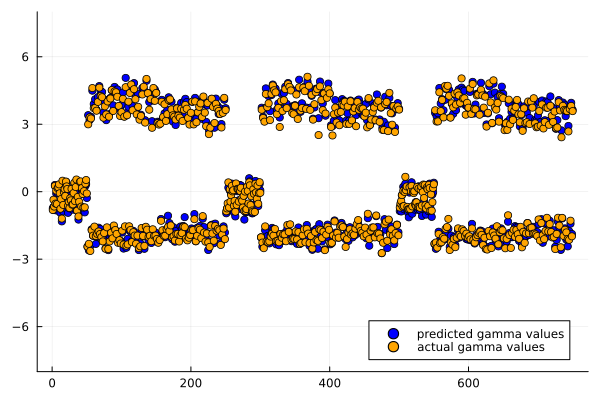

In [493]:
using Plots

x = 1:length(pred_gamma_values)
plot(x, pred_gamma_values, seriestype=:scatter, label = "predicted gamma values", mc=:blue)
plot!(x, actual_gamma_values, seriestype=:scatter, label = "actual gamma values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-8, 8)

In [494]:
model.V_gamma_star

3-element Vector{Vector{Vector{Vector{Matrix{Float64}}}}}:
 [[[[0.4355999999999996;;], [4.579599999999991;;], [2.4336000000000015;;], [0.12960000000000066;;], [4.1616;;], [2.131600000000001;;], [7.728399999999913;;], [0.4095999999999996;;], [2.4336000000000015;;], [3.686400000000003;;]  …  [2.3104000000000013;;], [3.3124000000000025;;], [6.451599999999946;;], [3.8416000000000032;;], [2.8224000000000022;;], [5.47559999999997;;], [5.107599999999979;;], [3.3124000000000025;;], [3.2400000000000024;;], [4.494399999999993;;]]], [[[7.658749628924512 -0.38394509357303935; -0.38394509357303935 2.5948034943414484], [5.787279016728209 -1.3024836934101744; -1.3024836934101744 2.0149475586418264], [2.9178342601606357 0.006344495994359508; 0.006344495994359508 2.2737648695322403], [0.043728487376256654 0.007480280622100043; 0.007480280622100043 0.04628473038745779], [7.973182784464851 -0.8008923056042665; -0.8008923056042665 3.799142252667267], [3.593056623878728 0.47480739297988056; 0.4748073929798

In [495]:
model.gamma_sample

3-element Vector{Vector{Vector{Vector{Vector{Vector{Float64}}}}}}:
 [[[[[-0.23014729074918228], [-1.9215057057057483], [-0.7120633804153539], [-0.24647850615455946], [-1.7666402094015274], [-0.9295881950891749], [-0.4963523519359467], [-1.075509084688336], [-1.2158477687897797], [-0.5995664750442629]  …  [-1.085538659690908], [0.7206950212116243], [-1.3981321669668945], [-1.0444198648236551], [-0.7102776586916003], [-1.5406465372251588], [-1.6576458012952617], [-0.6246428949617886], [-0.7397071773164906], [0.14517494548554633]], [[-3.426441784568947], [-3.6332817037250944], [-2.0942928141127437], [0.9992264641036865], [-3.260271257878544], [2.001078980832486], [-0.13318952608571433], [1.6803262959048229], [-2.8793926884281014], [3.371589667191562]  …  [2.1246181425398], [-1.8779861573492604], [-1.3657434135957736], [2.146984958070249], [1.4114598857814027], [-3.1326886604483626], [-2.4359458546722053], [-2.6605160447925353], [-3.7307009697144067], [-1.2763423366024653]], [[1.0583458031

**Estimating omega with correct gamma**

In [305]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [306]:
# Fix true values of gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
                model.V_gamma_star[k][1][1][s] = model.V_gamma_star[k][1][1][s] ./ 100
            end
        else
            for z in 0:1
                for s in 1:S
                    model.mu_gamma_star[k][t][z + 1][s] .= data[:gamma][k][t][z + 1, s, :]
                    model.V_gamma_star[k][t][z + 1][s] = model.V_gamma_star[k][t][z + 1][s] ./ 100
                end
            end
        end
    end
end


# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample tau
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [310]:
update_normal_variational_distribution3(model, init_step = .1, maxiter = 800, verbose = false)

In [311]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, feature, :])
                end
            end
        end
    end
end

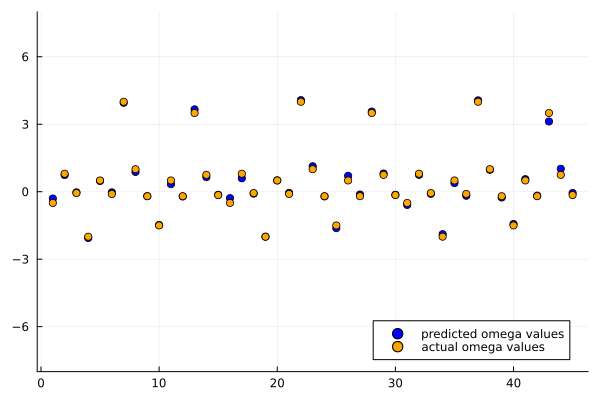

In [313]:
using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-8, 8)

In [130]:
model.a_tau_star

3-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]

In [131]:
model.b_tau_star

3-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[1.0]], [[1.0, 1.0], [1.0, 1.0]]]
 [[[1.0]], [[1.0, 1.0], [1.0, 1.0]]]
 [[[1.0]], [[1.0, 1.0], [1.0, 1.0]]]

**Estimate Attribute profile, Gamma, and Omega simultaneously**

In [536]:
M = 100
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [537]:
# profile_to_ind = Dict([0, 0]=>[0.997, 0.001, 0.001, 0.001], 
#                  [0, 1]=>[0.001, 0.997, 0.001, 0.001],
#                  [1, 0]=>[0.001, 0.001, 0.997, 0.001],
#                  [1, 1]=>[0.001, 0.001, 0.001, 0.997])

profile_to_ind = Dict([0, 0, 0] => [0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], 
                 [0, 0, 1] => [0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 0] => [0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 1] => [0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001],
                 [1, 0, 0] => [0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001],
                 [1, 0, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001],
                 [1, 1, 0] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001],
                 [1, 1, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993])

# Fix true values of pi
for i in 1:N
    for t in 1:O
        model.pi_star[i][t] .= profile_to_ind[Vector{Int}(data[:profiles][i, :, t])]
    end
end

# Fix true value of mu_beta
for j in 1:J
    model.mu_beta_star[j] = data[:beta][j]
    model.V_beta_star[j] = model.V_beta_star[j] ./ 100
end

# initialize true values of gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                #model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
                model.V_gamma_star[k][1][1][s] .= model.V_gamma_star[k][1][1][s] ./ 40
            end
        else
            for z in 0:1
                for s in 1:S
                    #model.mu_gamma_star[k][t][z + 1][s] .= data[:gamma][k][t][z + 1, s, :]
                    model.V_gamma_star[k][t][z + 1][s] .= model.V_gamma_star[k][t][z + 1][s] ./ 40
                end
            end
        end
    end
end

# initialize true values of omega
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                #model.mu_omega_star[k][t][1][feature] .= data[:omega][k][t]
                model.V_omega_star[k][t][1][feature] .= model.V_omega_star[k][t][1][feature] ./ 10
                model.a_tau_star[k][t][1][feature] = 1000
                model.b_tau_star[k][t][1][feature] = 1
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    #model.mu_omega_star[k][t][z + 1][feature] .= data[:omega][k][t][z + 1, :, feature]
                    model.V_omega_star[k][t][z + 1][feature] .= model.V_omega_star[k][t][z + 1][feature] ./ 10
                    model.a_tau_star[k][t][z + 1][feature] = 1000
                    model.b_tau_star[k][t][z + 1][feature] = 1
                end
            end
        end
    end
end

# Sample Z
for i in 1:N
    sample_Z(model, i, 1)
    sample_Z(model, i, 2)
end

# Sample beta
sample_β(model)

# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 0, feature)
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [538]:
for iter in 1:600
    # update_categorical_variational_distribution(model, maxiter=1, verbose=false)
    # for i in 1:N
    #     sample_Z(model, i, 1)
    # end

    # update_categorical_variational_distribution2(model, 2, maxiter=1, verbose=false)
    # for i in 1:N
    #     sample_Z(model, i, 2)
    # end
    update_normal_variational_distribution2(model, init_step = .005, maxiter = 10, verbose = false)
    for k in 1:K
        for t in 1:O
            if t == 1
                for s in 1:S
                    sample_γ(model, s, t, k, 0)
                end
            else
                for z in 0:1
                    for s in 1:S
                        sample_γ(model, s, t, k, z)
                    end
                end
            end
        end
    end

    update_normal_variational_distribution3(model, init_step = .005, maxiter = 100, verbose = false)
    for k in 1:K
        for t in 1:O
            num_features = length(model.gamma_sample[k][t][1][1][1])
            if t == 1
                for feature in 1:num_features
                    sample_ω(model, k, t, 0, feature)
                end
            else
                for z in 0:1
                    for feature in 1:num_features
                        sample_ω(model, k, t, z, feature)
                    end
                end
            end
        end
    end

    # update_inverse_gamma_distribution(model, step = 1e-6, maxiter = 30, verbose = false)
    # for k in 1:K
    #     for t in 1:O
    #         num_features = length(model.gamma_sample[k][t][1][1][1])
    #         if t == 1
    #             for feature in 1:num_features
    #                 sample_τ(model, k, t, 0, feature)
    #             end
    #         else
    #             for z in 0:1
    #                 for feature in 1:num_features
    #                     sample_τ(model, k, t, z, feature)
    #                 end
    #             end
    #         end
    #     end
    # end
end

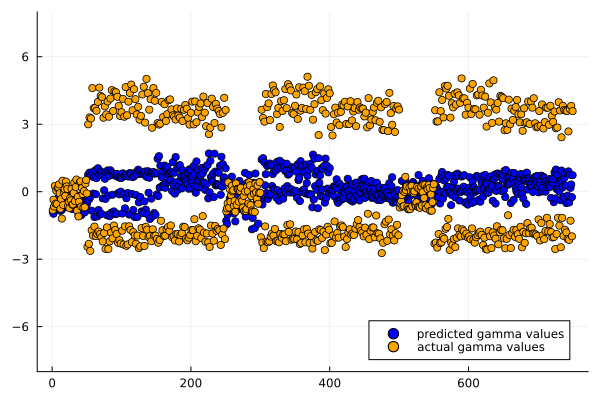

In [539]:
pred_gamma_values = []
actual_gamma_values = []
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                push!(pred_gamma_values, model.mu_gamma_star[k][t][1][s][1])
                push!(actual_gamma_values, data[:gamma][k][t][s])
            end
        else
            num_features = size(obs.X[k][t], 2)
            for z in 1:2
                for s in 1:S
                    for feature in 1:num_features
                        push!(pred_gamma_values, model.mu_gamma_star[k][t][z][s][feature])
                        push!(actual_gamma_values, data[:gamma][k][t][z, s, feature])
                    end
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_gamma_values)
plot(x, pred_gamma_values, seriestype=:scatter, label = "predicted gamma values", mc=:blue)
plot!(x, actual_gamma_values, seriestype=:scatter, label = "actual gamma values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-8, 8)

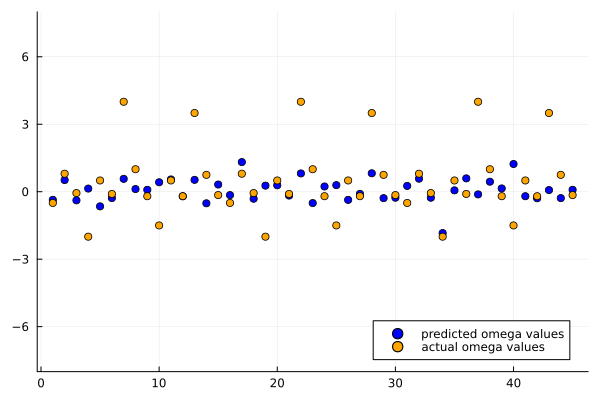

In [540]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, feature, :])
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-8, 8)

In [543]:
model.V_omega_star

3-element Vector{Vector{Vector{Vector{Matrix{Float64}}}}}:
 [[[[0.17833435348794527 0.007275903385176611 -0.05206927698445293; 0.007275903385176611 0.06224108891147071 0.004006328128158273; -0.05206927698445293 0.004006328128158273 0.018852487789400196]]], [[[0.11676933750964924 -0.047626265523891306 -0.03733222130917236; -0.047626265523891306 0.04750901661667134 0.0171642863392455; -0.03733222130917236 0.0171642863392455 0.013800085757457165], [0.22989583391215782 0.04292279223921025 -0.035568489601176784; 0.04292279223921025 0.11007030613847789 -0.0556684014487416; -0.035568489601176784 -0.0556684014487416 0.02983717301931782]], [[0.18614367507595014 0.011975198146490413 -0.05719847107877258; 0.011975198146490413 0.13565593136327878 -0.03520742680667693; -0.05719847107877258 -0.03520742680667693 0.03143484847566805], [0.1966673542387381 -0.03152700575530885 -0.029648146282900335; -0.03152700575530885 0.13035592488406902 0.0353653193332857; -0.029648146282900335 0.0353653193332857 0.0

In [544]:
model.V_gamma_star

3-element Vector{Vector{Vector{Vector{Matrix{Float64}}}}}:
 [[[[6.492884360780078;;], [3.834209978830231;;], [7.192513144511993;;], [0.047573665961010286;;], [13.45505945871869;;], [9.78509646506973;;], [18.646107506629445;;], [0.002692169136464041;;], [8.80970002250707;;], [8.632513189526572;;]  …  [9.973683298050227;;], [14.885042734261836;;], [8.51538863420624;;], [14.962305011922002;;], [13.45505945871869;;], [9.910621020390062;;], [13.676046291699187;;], [11.009879740612885;;], [5.560701085236911;;], [9.722634187409563;;]]], [[[3.5409572467697923 0.0923204493701045; 0.0923204493701045 4.170712604141407], [8.86732135898712 0.5206348445517752; 0.5206348445517752 8.767893193562019], [7.766594793915379 -2.1109294322242214; -2.1109294322242214 13.916402286617304], [0.028191362897787068 -0.007198726835537845; -0.007198726835537845 0.006202313050531566], [11.000352157616467 1.0874775076900307; 1.0874775076900307 9.093807748182169], [7.653575704873834 0.8303570518250032; 0.830357051825003

In [542]:
model.tau_sample

3-element Vector{Vector{Vector{Vector{Vector{Float64}}}}}:
 [[[[0.0009933394196272908, 0.0009481068488209757, 0.0010218662366388047, 0.0010012946106561784, 0.000959269382594998, 0.0009830902921820004, 0.000971257241953808, 0.0009897337301985776, 0.0009698861063792429, 0.001018277470497705  …  0.00104861469532237, 0.0010504017842843671, 0.0009708443723275163, 0.0009782471873342941, 0.0010236836788307105, 0.00103090864501026, 0.0010372509619905328, 0.000989038310608667, 0.0009804269257793173, 0.0010105937796128553]]], [[[0.00098966459916795, 0.0009633713710968607, 0.0010276705352702438, 0.0009283336072150604, 0.000927324278250929, 0.0009794412701313886, 0.000993020593033564, 0.0009964987956786828, 0.0009802971486076969, 0.0009360325444353762  …  0.0009587650472302434, 0.0010162531010789134, 0.0009807312574428642, 0.0009912402092644155, 0.0009916442653590395, 0.0009863958804010402, 0.0010479699867105077, 0.0009903286060282204, 0.0010052568793443722, 0.0009761245590917017], [0.001008302174

**Estimating Tau with true value of omega and gamma**

In [27]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [36]:
# initialize true values of gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
                model.V_gamma_star[k][1][1][s] .= model.V_gamma_star[k][1][1][s] ./30
            end
        else
            for z in 0:1
                for s in 1:S
                    model.mu_gamma_star[k][t][z + 1][s] .= data[:gamma][k][t][z + 1, s, :]
                    model.V_gamma_star[k][t][z + 1][s] .= model.V_gamma_star[k][t][z + 1][s] ./30
                end
            end
        end
    end
end

# initialize true values of omega
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                model.mu_omega_star[k][t][1][feature] .= data[:omega][k][t]
                model.V_omega_star[k][t][1][feature] .= model.V_omega_star[k][t][1][feature] ./ 30
                #model.a_tau_star[k][t][1][feature] = 10
                #model.b_tau_star[k][t][1][feature] = .01
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    model.mu_omega_star[k][t][z + 1][feature] .= data[:omega][k][t][z + 1, feature, :]
                    model.V_omega_star[k][t][z + 1][feature] .= model.V_omega_star[k][t][z + 1][feature] ./30
                    #model.a_tau_star[k][t][z + 1][feature] = 10
                    #model.b_tau_star[k][t][z + 1][feature] = .01
                end
            end
        end
    end
end

# # Initialize true values of tau
# for k in 1:K
#     for t in 1:O
#         num_features = length(model.gamma_sample[k][t][1][1][1])
#         if t == 1
#             for feature in 1:num_features
#                 model.a_tau_star[k][t][1][feature] = S/2
#                 model.b_tau_star[k][t][1][feature] = (S/2 - 1) * .04
#             end
#         else
#             for z in 0:1
#                 for feature in 1:num_features
#                     model.a_tau_star[k][t][z + 1][feature] = S/2
#                     model.b_tau_star[k][t][z + 1][feature] = (S/2 - 1) * .04
#                 end
#             end
#         end
#     end
# end

# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 0, feature)
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end



In [37]:
# for iter in 1:100
#     update_inverse_gamma_distribution(model, step = 1e-4, maxiter = 30, verbose = true)
#     for k in 1:K
#         for t in 1:O
#             num_features = length(model.gamma_sample[k][t][1][1][1])
#             if t == 1
#                 for feature in 1:num_features
#                     sample_τ(model, k, t, 0, feature)
#                 end
#             else
#                 for z in 0:1
#                     for feature in 1:num_features
#                         sample_τ(model, k, t, z, feature)
#                     end
#                 end
#             end
#         end
#     end
# end
update_inverse_gamma_distribution(model, step = 1e-4, maxiter = 2500, verbose = true)

ELBO: -28.76310894313251
b*: 73.46274782350909
ELBO: -27.8317095331211
gradient log(b*): -38.787997645389254
ELBO: -57.8692710427161
ELBO: -59.82869850294966
b*: 72.54933822857768
ELBO: -59.57358923934806
gradient log(b*): -19.278201501755024
b*: 235.35258554378814
gradient log(b*): -73.55642902718336
b*: 264.67558715863635
ELBO: -55.243158914077995
gradient log(b*): -3.6421093176842083
ELBO: -28.34440720756931
b*: 263.2627231716264
ELBO: -57.02700674159998
b*: 233.6277673186014
gradient log(b*): -37.629934149245756
gradient log(b*): -29.69946447113154
b*: 226.11907799560768
b*: 72.40961088033208
gradient log(b*): 17.700172633312526
gradient log(b*): -32.48444690844713
ELBO: -27.99921174473729
ELBO: -60.411573964691726
b*: 264.5792069688457
gradient log(b*): -59.130530173270586
b*: 73.17835244747033
gradient log(b*): -16.9837047425265
ELBO: -56.96487607843468
b*: 232.75027959434598
gradient log(b*): -33.83814480685877
ELBO: -27.536248037593985
b*: 72.17477389828318
ELBO: -59.2765785390

Excessive output truncated after 524293 bytes.

gradient log(b*): -20.78483816346831
gradient log(b*): -13.107057069916298
gradient log(b*): -14.326132515548725
ELBO: -2.9164779653467314
gradient log(b*): -18.895355667493877
b*: 25.04780475791998
ELBO: 1.0655789114833512
gradient log(b*): -22.989414090485187
b*: 21.270150493119456
gradient log(b*): -24.872750073635583
ELBO: -0.9128525504146857
b*: 22.842788793038448
ELBO: 23.210182212992443
b*: 7.027526234886779
gradient log(b*): -17.279329614670676
gradient log(b*): -20.673369408152944
ELBO: 22.665584816014164
b*: 7.435596748143748
gradient log(b*): -19.15208317902059
ELBO: 2.3411907946086337
b*: 21.024337128712215
gradient log(b*): -26.62419706112035
ELBO: -2.62223140187439
b*: 24.990287462134944
ELBO: 1.092293317405506
gradient log(b*): -22.246853101630457
b*: 21.21731151916558
ELBO: 22.60331872090682
b*: 7.4213696596710035
ELBO: -1.0780911336579655
gradient log(b*): -20.05033965534945
b*: 22.795613832006847
gradient log(b*): -15.701370583213382
ELBO: 1.3663294730829154
b*: 20.96

In [34]:
update_inverse_gamma_distribution_va(model)

In [38]:
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end
mean(model.tau_sample[2][2][1][2])

0.1766766364616565

In [39]:
model.a_tau_star

2-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]

In [40]:
model.b_tau_star

2-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[2.3681007816235304]], [[2.3702876907359554, 3.794422887833501], [2.4628769709861396, 2.7068913255937894]]]
 [[[2.1758986604781922]], [[2.488155736819653, 4.215812415266939], [2.281293200404011, 3.5601861029816533]]]

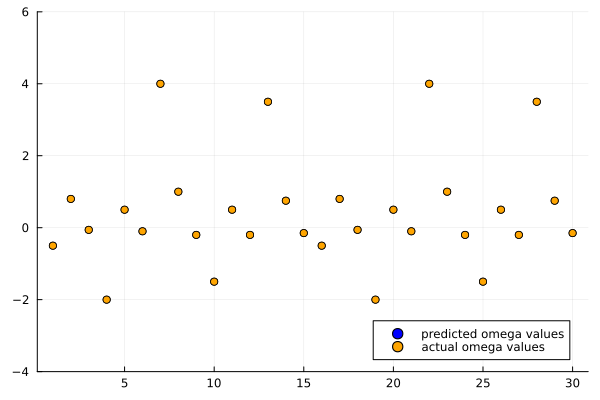

In [33]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, feature, :])
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-4, 6)

In [439]:
model.a_tau_prior

2-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]

In [440]:
model.b_tau_prior

2-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[1.0]], [[1.0, 1.0], [1.0, 1.0]]]
 [[[1.0]], [[1.0, 1.0], [1.0, 1.0]]]

In [441]:
est = 0
for s in 1:50
    est += (model.mu_gamma_star[2][2][1][s][1] - dot(model.obs.U[2][2][s, :], model.mu_omega_star[2][2][1][1]))
end
(model.b_tau_prior[2][2][1][1] + 1/2 * est) / (25 + model.a_tau_prior[2][2][1][1] + 1)

0.0449975722238702

In [442]:
est = 0
for s in 1:50
    est += (model.mu_gamma_star[2][2][1][s][1] - dot(model.obs.U[2][2][s, :], model.mu_omega_star[2][2][1][1]))
end
(1/2 * est) / (25)

0.05179504733669521

In [483]:
a = S/2
est = 0
for s in 1:50
    est += (model.mu_gamma_star[2][2][1][s][1] - dot(model.obs.U[2][2][s, :], model.mu_omega_star[2][2][1][1]))^2
end
(model.b_tau_prior[2][2][1][1] * (a - 1) + (a - 1)/2 * est) / (model.a_tau_prior[2][2][1][1] + 1 + S/2)

0.4798817361766747

In [484]:
a = S/2
est = 0
for s in 1:50
    est += (model.mu_gamma_star[2][2][1][s][1] - dot(model.obs.U[2][2][s, :], model.mu_omega_star[2][2][1][1]))^2
end
((a - 1)/2 * est) / (S/2)

0.018958741800416245

In [457]:
rand(InverseGamma(25, 1))

0.06660945577445676

**Estimating full TDCM model**

In [445]:
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 16 threads


In [446]:
# Initialize tau distribution
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                model.a_tau_star[k][t][1][feature] = 500.0
                model.b_tau_star[k][t][1][feature] = 1.0
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    model.a_tau_star[k][t][z + 1][feature] = 500.0
                    model.b_tau_star[k][t][z + 1][feature] = 1.0
                end
            end
        end
    end
end

In [447]:
# Initialize small tau values
# for k in 1:K
#     for t in 1:O
#         num_features = length(model.gamma_sample[k][t][1][1][1])
#         if t == 1
#             for feature in 1:num_features
#                 model.a_tau_star[k][t][1][feature] = 3
#                 model.b_tau_star[k][t][1][feature] = 3
#             end
#         else
#             for z in 0:1
#                 for feature in 1:num_features
#                     model.a_tau_star[k][t][z + 1][feature] = 3
#                     model.b_tau_star[k][t][z + 1][feature] = 3
#                 end
#             end
#         end
#     end
# end

# Initialize random gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                #model.mu_gamma_star[k][1][1][s] .= 2.0
                model.V_gamma_star[k][1][1][s] = model.V_gamma_star[k][1][1][s] ./ 50
            end
        else
            for z in 0:1
                for s in 1:S
                    #model.mu_gamma_star[k][t][z + 1][s] .= 2.0
                    model.V_gamma_star[k][t][z + 1][s] = model.V_gamma_star[k][t][z + 1][s] ./ 50
                end
            end
        end
    end
end

# Initialize attribute profiles as no masteries
# for i in 1:N
#     for t in 1:O
#         model.pi_star[i][t] .= [0.4, 0.2, 0.2, 0.2]
#     end
# end

# Initialize betas in the correct direction
for j in 1:J
    model.mu_beta_star[j] = data[:beta][j]/5
end

# Sample Z values
for i in 1:N
    for t in 1:O
        sample_Z(model, i, t)
    end
end

# Sample beta
sample_β(model)

# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 0, feature)
                sample_τ(model, k, t, 0, feature)
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [455]:
for iter in 1:100
    update_categorical_variational_distribution(model, maxiter=1, verbose=false)
    for i in 1:N
        sample_Z(model, i, 1)
    end

    update_categorical_variational_distribution2(model, 2, maxiter=1, verbose=false)
    for i in 1:N
        sample_Z(model, i, 2)
    end

    update_normal_variational_distribution(model, init_step = .01, maxiter = 10, verbose = false)
    sample_β(model)

    update_normal_variational_distribution2(model, init_step = .01, maxiter = 10, verbose = false)
    for k in 1:K
        for t in 1:O
            if t == 1
                for s in 1:S
                    sample_γ(model, s, t, k, 0)
                end
            else
                for z in 0:1
                    for s in 1:S
                        sample_γ(model, s, t, k, z)
                    end
                end
            end
        end
    end

    update_normal_variational_distribution3(model, init_step = .05, maxiter = 100, verbose = false)
    for k in 1:K
        for t in 1:O
            num_features = length(model.gamma_sample[k][t][1][1][1])
            if t == 1
                for feature in 1:num_features
                    sample_ω(model, k, t, 0, feature)
                end
            else
                for z in 0:1
                    for feature in 1:num_features
                        sample_ω(model, k, t, z, feature)
                    end
                end
            end
        end
    end

    update_inverse_gamma_distribution(model, step = 1e-5, maxiter = 1, verbose = false)
    for k in 1:K
        for t in 1:O
            num_features = length(model.gamma_sample[k][t][1][1][1])
            if t == 1
                for feature in 1:num_features
                    sample_τ(model, k, t, 0, feature)
                end
            else
                for z in 0:1
                    for feature in 1:num_features
                        sample_τ(model, k, t, z, feature)
                    end
                end
            end
        end
    end
end

In [521]:
skill_profiles = Dict(1=>[0, 0, 0], 
                 2=>[0, 0, 1],
                 3=>[0, 1, 0],
                 4=>[0, 1, 1],
                 5=>[1, 0, 0],
                 6=>[1, 0, 1],
                 7=>[1, 1, 0],
                 8=>[1, 1, 1])

skill_numbers = Dict([0, 0, 0]=>1, 
                 [0, 0, 1]=>2,
                 [0, 1, 0]=>3,
                 [0, 1, 1]=>4,
                 [1, 0, 0]=>5,
                 [1, 0, 1]=>6,
                 [1, 1, 0]=>7,
                 [1, 1, 1]=>8)

preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:5000
    pred = skill_profiles[argmax(model.pi_star[i][2])]
    actual = Vector{Int}(data[:profiles][i, :, 2])
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
    # if !correct
    #     print(Vector{Int}(data[:profiles][i, 1, :]))
    #     println(model.pi_star[i][1])
    # end
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
;

In [522]:
accuracy

1.0

In [523]:
attribute_accs

8-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

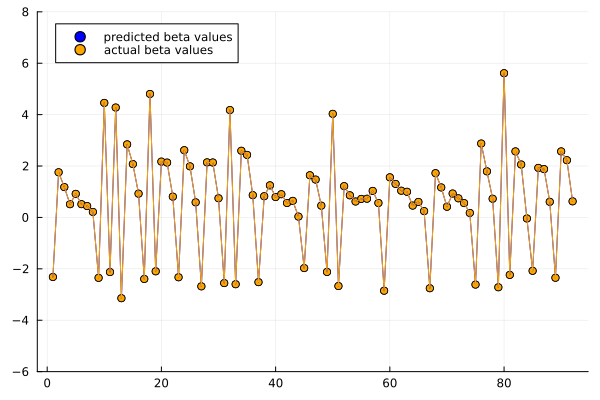

In [515]:
pred_beta_values = []
actual_beta_values = []
for j in 1:21
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data[:beta][j]
        push!(actual_beta_values, val)
    end
end

using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
plot!(x, pred_beta_values, label = "", lc=:blue)
plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-6, 8)

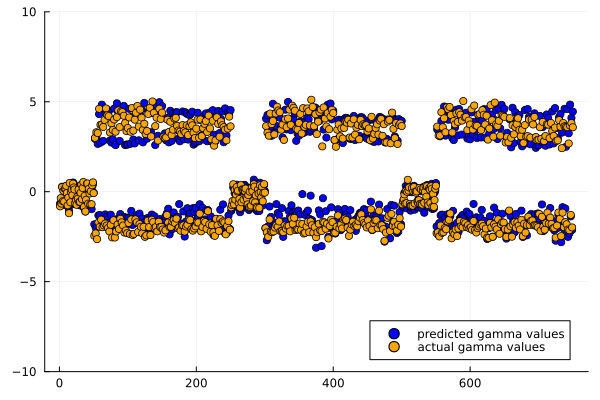

In [516]:
pred_gamma_values = []
actual_gamma_values = []
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                push!(pred_gamma_values, model.mu_gamma_star[k][t][1][s][1])
                push!(actual_gamma_values, data[:gamma][k][t][s])
            end
        else
            num_features = size(obs.X[k][t], 2)
            for z in 1:2
                for s in 1:S
                    for feature in 1:num_features
                        push!(pred_gamma_values, model.mu_gamma_star[k][t][z][s][feature])
                        push!(actual_gamma_values, data[:gamma][k][t][z, s, feature])
                    end
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_gamma_values)
plot(x, pred_gamma_values, seriestype=:scatter, label = "predicted gamma values", mc=:blue)
plot!(x, actual_gamma_values, seriestype=:scatter, label = "actual gamma values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-10, 10)

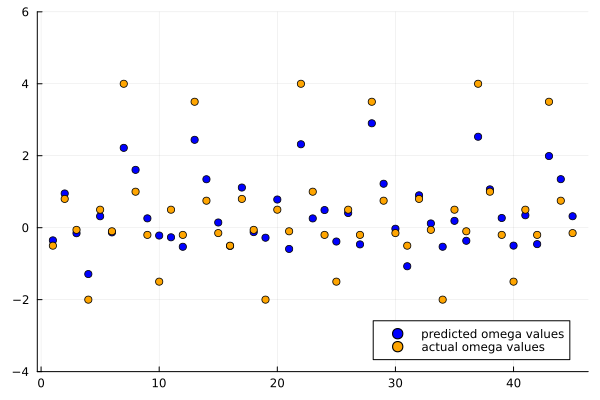

In [517]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, feature, :])
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-4, 6)

In [518]:
model.a_tau_star

3-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[50.0]], [[50.0, 50.0], [50.0, 50.0]]]
 [[[50.0]], [[50.0, 50.0], [50.0, 50.0]]]
 [[[50.0]], [[50.0, 50.0], [50.0, 50.0]]]

In [519]:
model.b_tau_star

3-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[2.0]], [[2.0, 2.0], [2.0, 2.0]]]
 [[[2.0]], [[2.0, 2.0], [2.0, 2.0]]]
 [[[2.0]], [[2.0, 2.0], [2.0, 2.0]]]

In [520]:
model.tau_sample

3-element Vector{Vector{Vector{Vector{Vector{Float64}}}}}:
 [[[[0.03480267915379762, 0.04111476526107702, 0.05202068753430606, 0.05072846903265691, 0.049786895368256034, 0.0446376945910719, 0.04019188979730506, 0.03799850837345206, 0.04231207903913739, 0.045633832295006796  …  0.0343382475298302, 0.03901760000751086, 0.033043316373645104, 0.04457541710756391, 0.04476332931140341, 0.041801506218354295, 0.03617521266025158, 0.0408823781376642, 0.03594860777492433, 0.03575438184596282]]], [[[0.041860110950902106, 0.041301886832169, 0.0420674969602569, 0.05532036263358305, 0.03935376636391569, 0.03558625425317548, 0.03994508180722043, 0.033794825848896246, 0.04597357423552699, 0.04034580171419195  …  0.04727975851337703, 0.045390119564538346, 0.038885765241847, 0.03761901260517699, 0.033295041360936875, 0.04227139316677181, 0.0368626272493124, 0.033129044327320625, 0.042901489517817346, 0.04094031167127002], [0.043655161178479666, 0.04142228429732911, 0.037094447698813496, 0.04534713990952

In [524]:
model.V_gamma_star

3-element Vector{Vector{Vector{Vector{Matrix{Float64}}}}}:
 [[[[0.8989199351533032;;], [1.6592373755990129;;], [0.7710839915321243;;], [0.28956655108639867;;], [1.140867267075321;;], [1.0162936011143133;;], [3.055902147966719;;], [0.07734733192202056;;], [1.8717355968803544;;], [0.9962313234541452;;]  …  [5.189802863955576;;], [1.8717355968803544;;], [1.8717355968803544;;], [1.5577882649583419;;], [0.93724449047364;;], [2.2744074841227007;;], [2.849728482005715;;], [1.4595391543176708;;], [1.5577882649583419;;], [2.2744074841227007;;]]], [[[2.526762489670899 -0.4834333884433451; -0.4834333884433451 3.038037822666888], [0.6335952273836931 0.1615077132805728; 0.1615077132805728 0.8325000578747268], [2.3350629845835935 -0.18526633394513342; -0.18526633394513342 9.790065970165594], [0.05831268514467493 0.00751458027866916; 0.00751458027866916 0.07598316310326954], [3.20707251964592 -0.17794120306871913; -0.17794120306871913 4.045432497008575], [2.021097869770074 0.5162121468579257; 0.51621